In [227]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Imputer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import itertools
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=6,suppress=True)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
pd.set_option('precision', 6)
pd.set_option('display.float_format',lambda x : '%.2f' % x)

## 读取数据并查看数据信息

In [237]:
#读取数据
data = pd.read_csv("Data.csv")
#查看数据信息
data.info()
#共有15万条数据，数据类型有float64和int64两种，第一列数据为编号数据，应当删去

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
Unnamed: 0    150000 non-null int64
y             150000 non-null int64
x1            150000 non-null float64
x2            150000 non-null int64
x3            150000 non-null int64
x4            150000 non-null float64
x5            120269 non-null float64
x6            150000 non-null int64
x7            150000 non-null int64
x8            150000 non-null int64
x9            150000 non-null int64
x10           146076 non-null float64
dtypes: float64(4), int64(8)
memory usage: 13.7 MB


###  查看数据信息
1. 发现第一列是编号数据，属于多余信息，应该删去。
2. x5列共有缺失值29731个，x10列有3924个缺失值，需要进行平滑处理
3. y为预测结果，取值为0和1两种，所以这是一个二分类问题
4. x1 - x10为属性列，因没有指明属性指标故不对数据进行异常值分析

In [229]:
data.describe()

,Unnamed: 0,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,150000.00,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,75000.50,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,43301.41,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,37500.75,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,75000.50,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,112500.25,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,150000.00,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


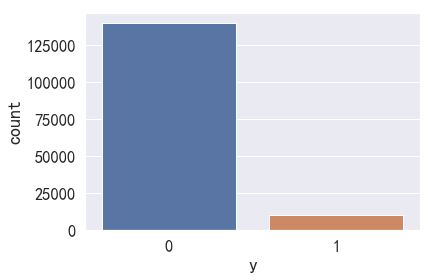

In [230]:
#查看y的分布，可知y值绝大部分为0
sns.countplot(x = data.y)

### 数据预处理

In [238]:
#删除编号列
data.drop(columns='Unnamed: 0',axis=1,inplace=True)
data.columns #查看列名，发现编号列已删除

Index(['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10'], dtype='object')

###  缺失值处理
缺失值处理的方法，包括如下几种:<br>
１．直接删除含有缺失值的样本。<br>
２．根据样本之间的相似性填补缺失值。<br>
３．根据变量之间的相关关系填补缺失值。<br>
变量x5缺失率比较大，所以我们根据变量之间的相关关系填补缺失值，我们采用随机森林法：

In [239]:
# 用随机森林对缺失值预测填充函数
def set_missing(df):
    # 把已有的数值型特征取出来
    process_df = df.iloc[:,[5,0,1,2,3,4,6,7,8,9]]
    # 分成已知该特征和未知该特征两部分
    known = process_df[process_df.x5.notnull()].as_matrix()
    unknown = process_df[process_df.x5.isnull()].as_matrix()
    # X为特征属性值
    X = known[:, 1:]
    # y为结果标签值
    y = known[:, 0]
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, 
    n_estimators=200,max_depth=3,n_jobs=-1)
    rfr.fit(X,y)
    # 用得到的模型进行未知特征值预测
    predicted = rfr.predict(unknown[:, 1:]).round(0)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.x5.isnull()), 'x5'] = predicted
    return df

In [240]:

#对x5列的缺失值进行填充
set_missing(data)
#发现x5列的空值数据已填充完毕
data.x5.isnull().sum()

0

In [241]:
#x10变量缺失值比较少，在这里直接采用均值填充方法，即缺失值填充为所在列的均值
data['x10'].fillna(data.x10.mean(),inplace=True)
#发现x10的缺失值已填充完毕
data.x10.isnull().sum()

0

### 查看各变量间的相关性


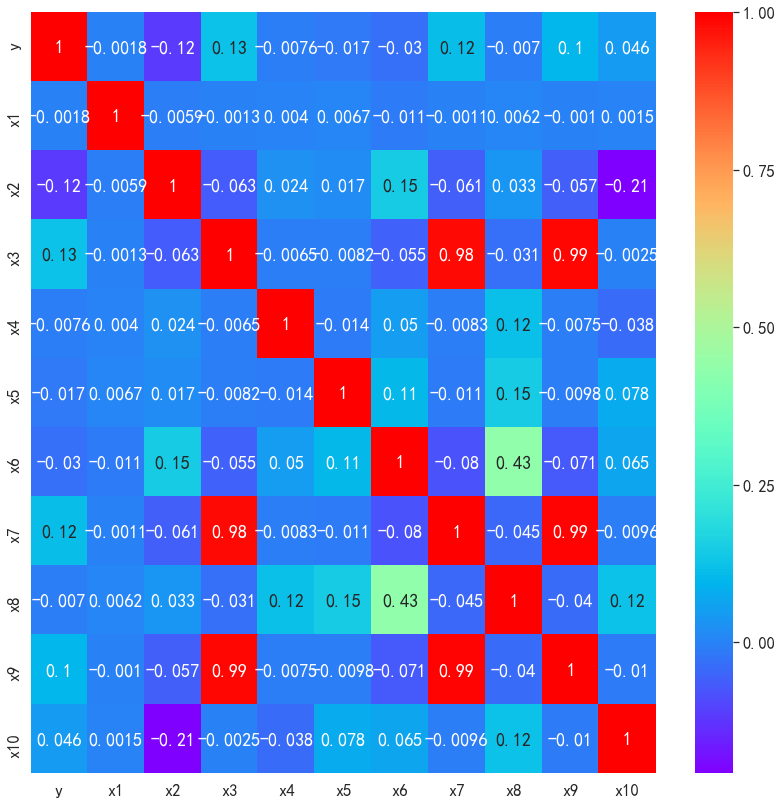

In [242]:
import seaborn as sns
corr = data.corr()#计算各变量的相关性系数
xticks = list(corr.index)
yticks = list(corr.index)
fig = plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True, cmap='rainbow')
plt.show()
#可知与y相关性最高的有x3,x7,x9等

## 划分数据集
划分数据集为训练集和测试集两部分，训练集用于训练模型，测试集用于查看模型效能

In [243]:
from sklearn.model_selection import train_test_split
Y = data['y']  #预测值列
X = data.iloc[:, 1:]  #属性列
#测试集占比30%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
train = pd.concat([Y_train, X_train], axis=1) #训练集
test = pd.concat([Y_test, X_test], axis=1)    #测试集
#clasTest = test.groupby('y')['y'].count()     #
train.to_csv('TrainData.csv',index=False)  #保存训练数据
test.to_csv('TestData.csv',index=False)    #保存测试数据
print('训练集维度信息：{0}\n测试集维度信息：{1}'.format(train.shape,test.shape))
#可知训练集共有105000条数据，测试集有45000条数据

训练集维度信息：(105000, 11)
测试集维度信息：(45000, 11)


In [250]:

#可视化ROC曲线
def plot_roc(Y, Y_scores):
    fpr, tpr, thresholds = roc_curve(Y, Y_scores, pos_label = 1)
    plt.figure(1, figsize=(6,6))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC曲线')
    plt.plot(fpr, tpr)
    plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    plt.show()
#训练模型及评估模型效能   
def eval_model(pipe, X_train, Y_train, X_test, Y_test):
    pipe.fit(X_train, Y_train)
    predicted_test = pipe.predict(X_test)
    scores_test = pipe.predict_proba(X_test)[:,1]
    predicted_train = pipe.predict(X_train)
    scores_train = pipe.predict_proba(X_train)[:,1]
    print()
    print("模型在训练集上的预测结果:")
    print(classification_report(Y_train, predicted_train))
    print('Roc_auc_分数:', roc_auc_score(Y_train, scores_train))
    print()
    print("模型在测试集上的预测结果:")
    print(classification_report(Y_test, predicted_test))
    print('Roc_auc_分数:', roc_auc_score(Y_test, scores_test))
    plot_roc(Y_test, scores_test)
    

### 用随机森林分类器训练


模型在训练集上的预测结果:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98009
           1       1.00      0.99      0.99      6991

   micro avg       1.00      1.00      1.00    105000
   macro avg       1.00      0.99      1.00    105000
weighted avg       1.00      1.00      1.00    105000

Roc_auc_分数: 0.9999840837657652

模型在测试集上的预测结果:


No handles with labels found to put in legend.


              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41965
           1       0.53      0.18      0.27      3035

   micro avg       0.93      0.93      0.93     45000
   macro avg       0.73      0.58      0.62     45000
weighted avg       0.92      0.93      0.92     45000

Roc_auc_分数: 0.8289172097796254


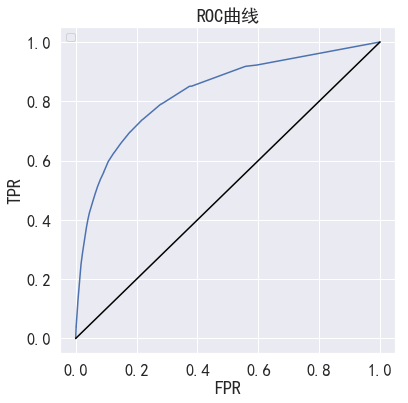

In [251]:
rmfc = RandomForestClassifier(n_estimators=50, max_features = 'sqrt')
pipe = Pipeline([
    ('imp',Imputer()),
    ('std',StandardScaler()),
    ('for', rmfc)])
eval_model(pipe, X_train, Y_train,X_test, Y_test)

### 用朴素贝叶斯中的高斯模型训练


模型在训练集上的预测结果:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     98009
           1       0.38      0.02      0.04      6991

   micro avg       0.93      0.93      0.93    105000
   macro avg       0.66      0.51      0.50    105000
weighted avg       0.90      0.93      0.90    105000

Roc_auc_分数: 0.704671745974292

模型在测试集上的预测结果:


No handles with labels found to put in legend.


              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41965
           1       0.48      0.03      0.05      3035

   micro avg       0.93      0.93      0.93     45000
   macro avg       0.70      0.51      0.51     45000
weighted avg       0.90      0.93      0.90     45000

Roc_auc_得分: 0.7015667838048927


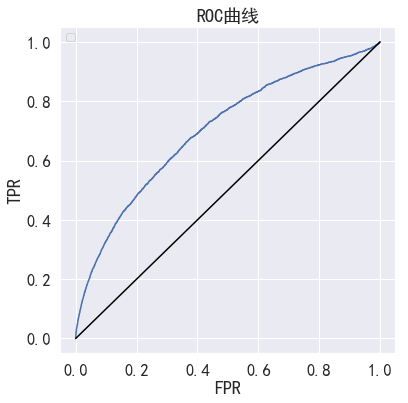

In [249]:
from sklearn.naive_bayes import GaussianNB

gnv = GaussianNB()
pipe = Pipeline([
    ('imp',Imputer()),
    ('std',StandardScaler()),
    ('nb',gnv)])

eval_model(pipe, X_train, Y_train, X_test, Y_test)

### 用AdaBoost分类器进行训练


模型在训练集上的预测结果:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     98009
           1       0.56      0.22      0.31      6991

   micro avg       0.94      0.94      0.94    105000
   macro avg       0.75      0.60      0.64    105000
weighted avg       0.92      0.94      0.92    105000

Roc_auc_分数: 0.8657061778160813

模型在测试集上的预测结果:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41965
           1       0.56      0.20      0.30      3035

   micro avg       0.94      0.94      0.94     45000
   macro avg       0.75      0.60      0.63     45000
weighted avg       0.92      0.94      0.92     45000



No handles with labels found to put in legend.


Roc_auc_得分: 0.8550124750934871


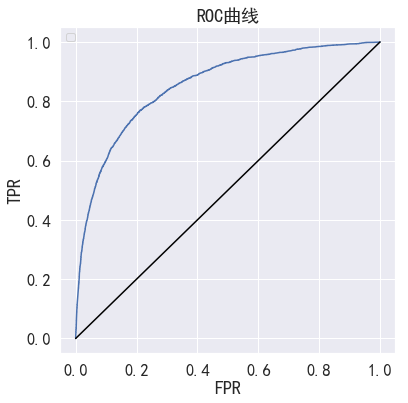

In [248]:
from sklearn.ensemble import AdaBoostClassifier

adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=1.0)

pipe = Pipeline([
    ('imp',Imputer()),
    ('std',StandardScaler()),
    ('adaMod', adaMod)
])
eval_model(pipe, X_train, Y_train, X_test, Y_test)

#### 三种方法的结果比较
使用随机森林、高斯模型、AdaBoost三种方法进行建模，在测试集上得到的AUC分数分别为0.828917，0.701567，0.855012。
可见在该训练数据和训练环境中AdaBoost取得的效果最好，其次为随机森林方法。